# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/human_body_temperature.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [2]:
def ecdf(series):
    ''' Return x-axis and values of the sample CDF of a list of oservations'''
    y = np.arange(len(series))/len(series)
    x = np.sort(series)
    return x,y


def bs_statistic (obs, func, size = 1) :
    ''' Return statistics from bootstrapped samples '''
    stat = np.empty(size)
    for  i in range(size):
        stat[i] = func(np.random.choice(obs,len(obs)))
        
    return stat    

def bs_unpaired_statistics (series1, series2, fun, size = 1) :
    ''' Return statistics from permutated bootstrapped samples '''
    series = series1.append(series2)
    stat = np.empty(size)
    for i in range(size):
        temp_perm = np.random.permutation(series)
        stat[i] = fun(temp_perm[:len(series1)]) - fun(temp_perm[len(series1):])
    return stat
  

In [3]:
mu_temp = df.temperature.mean()
sigma_temp = df.temperature.std(ddof=1)

print('The observed temperature has sample mean ' + str(mu_temp) + ' and sample standard deviation ' + str(sigma_temp))

The observed temperature has sample mean 98.24923076923078 and sample standard deviation 0.7331831580389454


### 1) The hypothesis of normality for the temperature distribution cannot be rejected.

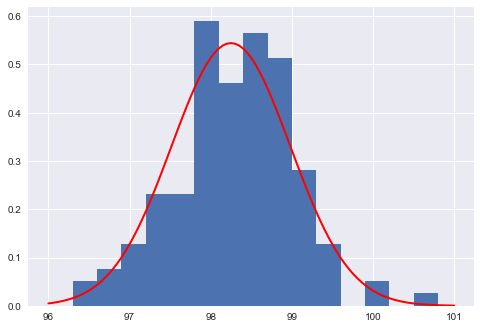

In [4]:
# Compare empirical CDF of the temperature data with the CDF of a Normal distr with mean mu_temp and std std_temp

sns.set()

plt.hist(df['temperature'], normed=1, bins=15)
x = 96 + ((np.arange(0,101))/100)*5 
plt.plot(x, 1/(sigma_temp * np.sqrt(2 * np.pi)) * np.exp( - (x - mu_temp)**2 / (2 * sigma_temp**2) ),linewidth=2, color='r')
plt.show()


In [5]:
# Perform normality test and plot the p-value

from scipy.stats.mstats import normaltest

stat_temp_norm, pi_temp_norm = normaltest(df['temperature'])

print('The p-value for the normality test is ' + str(pi_temp_norm) + ': the normality assumption cannot be rejected')

The p-value for the normality test is 0.258747986349: the normality assumption cannot be rejected


### (2) There are only 130 observations, not a very large sample. 

As for the independence, it depends on the circumstances in which the observations are captured. For insance, if multiple observations come from the same individual, those won't be independent. Since in the description of the dataset, this is not specified, I assume that the samples are taken by different individual under similar environmental conditions.

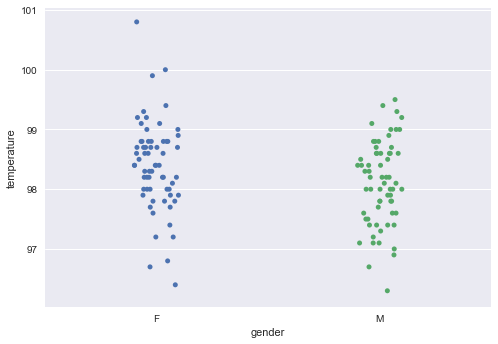

In [6]:
sns.stripplot(data = df, x = 'gender', y = 'temperature', jitter = True)
plt.show()



### (3 - a) - We bootsrap 10000 copies of the meand and observe that the 95% confidence interval for the mean temperature is [ 98.12307692,  98.37384615]. In particular 98.6 is way above.

### We also compute the p-value for the 98.6 mean and obtain a value of 0.0, hence the hypothesis that the mean temperature is 98.6 can be rejected.

In [7]:
# Sample 10000 bootstrapped means
bs_mean = bs_statistic (df['temperature'], np.mean, 10000)

print('The confidence interval for the mean temperature is ', np.percentile(bs_mean, [2.5, 97.5]))

The confidence interval for the mean temperature is  [ 98.12307692  98.37384615]


In [9]:
diff_obs = mu_temp - 98.6

# Enforce null hypothesis: H_0 is that mean temperature is 98.6
temp_rescaled = df['temperature'] - diff_obs

# Sample 10000 bootstrapped means
bs_mean = bs_statistic (temp_rescaled, np.mean, 10000)

# Compute the p-value
p_temp = np.sum( bs_mean <= mu_temp )/len(bs_mean)
print('The p-value for the test of mean=98.6 is ' + str(p_temp) + ': the hypothesis can be rejected')

The p-value for the test of mean=98.6 is 0.0: the hypothesis can be rejected


### (3-b) We aim to compare the mean of the observed temperatures with 98.6, hence a one-sample t-test looks like the way to go.

Since we do not know the std of the temperature, we should perform a t-test with 129 degrees of freedom. As required we also treat the statistic as normally distributed. Note that the p-value in the latter case is even lower. The reason for this is that the student distribution converges to a normal as the degrees of freedom grow to infinity and has heavier tails than the normal, i.e., more likely to have extreme outcomes.

In [11]:
# Compute the t-statistic
t_stat = (mu_temp - 98.6) / (sigma_temp/np.sqrt(len(df['temperature'])))

from scipy.stats import t, norm
pi_t = t.cdf(t_stat, len(df['temperature']) -1)
pi_z = norm.cdf(t_stat)

print('The p-values are given by ' +str(pi_t) + ' and ' +str(pi_z) + ' respectively when we consider the statistic to be student and normally distributed')


The p-values are given by 1.20531602078e-07 and 2.45107850706e-08 respectively when we consider the statistic to be student and normally distributed


### (4) When the sample is small we cannot treat the statistic as normally distributed, the bias is very large.


In [12]:
np.random.seed(1)

# Sample 10 observations from df['temperature]
obs_10 = np.random.choice(df['temperature'],10)
mu_temp_10 = np.mean(obs_10)
sigma_temp_10 = np.std(obs_10, ddof=1)

# Compute the t-statistic
stat_10 = (mu_temp_10 - 98.6) / (sigma_temp_10/np.sqrt(10))

from scipy.stats import t, norm
pi_t = t.cdf(stat_10, 9)
pi_z = norm.cdf(stat_10)

print('The p-values are given by ' +str(pi_t) + ' and ' +str(pi_z) + ' respectively when we consider the statistic to be student and normally distributed')


The p-values are given by 0.0208632760645 and 0.00883021692489 respectively when we consider the statistic to be student and normally distributed


### (5) We samples 10000 observations from a normal distribution with mean and std equal to the observed sample.  

In [14]:
bs_extraction = np.random.normal(mu_temp,sigma_temp, 10000)
np.percentile(bs_extraction,[75, 90, 95, 97.5, 99])

print('Only 10% of the population has a temperature higher than ' + str(np.percentile(bs_extraction,90)) + ' degrees.')

Only 10% of the population has a temperature higher than 99.1922702422 degrees.


### (6) From the plot of the comulative distribution we suspect that the two distributions are not the same. Moreover the difference in the mean is quite large. We test the hypothesis $H_0: \mu_M = \mu_F$ 

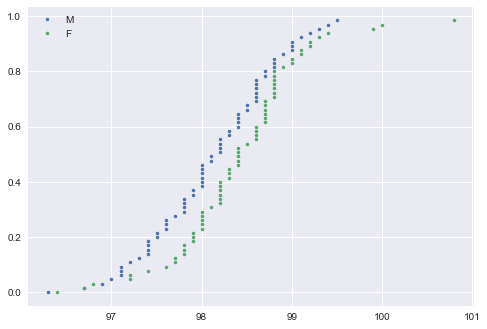

The observed difference in means is 0.289230769230727


In [15]:
temp_fem = df.loc[df['gender'] == 'F', 'temperature']
temp_male = df.loc[df['gender'] == 'M', 'temperature']

x_male,y_male = ecdf(temp_male)
x_fem,y_fem = ecdf(temp_fem)

plt.plot(x_male,y_male, marker = '.', linestyle = 'None', label = 'M')
plt.plot(x_fem,y_fem, marker = '.', linestyle = 'None', label = 'F')
plt.legend()
plt.show()

diff_means = np.mean(temp_fem) - np.mean(temp_male)

print('The observed difference in means is ' + str(diff_means))

In [16]:
# Compute the bootstrapped difference of means by enforcing the null-hypothesis stating that the means are the same
bs_diff = bs_unpaired_statistics (temp_fem, temp_male, np.mean, size = 100)

pi_value = np.sum(bs_diff > diff_means)/len(bs_diff)
pi_value

0.01